In [21]:
%load_ext autoreload
%autoreload 2

PRETRAINED_MODEL="prajjwal1/bert-small"
TASK="mrpc"
FINETUNED_PATH="bert-small-mrpc"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Load Pretrained Model 

Code for loading a pretrained BERT checkpoint

In [22]:
from transformers import BertForSequenceClassification, BertTokenizerFast

model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL)
tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)

loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/patrick/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-small/resolve/main/pytorch_model.bin from cache at /home/patrick/.cache/huggingface/transformers/facfdb1638fdec899406e0

## Load Dataset

Loads the dataset for GLUE task

In [23]:
from datasets import load_dataset

dataset = load_dataset('glue', TASK)

Reusing dataset glue (/home/patrick/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Finetune

In [45]:
from datasets import load_metric
import numpy as np

def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [52]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = FINETUNED_PATH, 
    evaluation_strategy="epoch"
)
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Evaluating on Squad

Code for running evaluation on finetuned model on squad

In [53]:
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained(FINETUNED_PATH)
tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)

eval_args = TrainingArguments(
    output_dir = FINETUNED_PATH,
    do_train = False,
    do_predict = True,
    dataloader_drop_last = False    
)

trainer = Trainer(
    model,
    eval_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

loading configuration file bert-small-mrpc/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file bert-small-mrpc/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model ch

In [60]:
import numpy as np
from datasets import load_metric
from timeit import default_timer as timer
from torch.profiler import profile, record_function, ProfilerActivity

start = timer()
outputs = trainer.predict(tokenized_datasets["test"])
end = timer()
delta = end-start
metric = load_metric("glue", TASK)
predictions = np.argmax(outputs.predictions, axis=-1)
with profile(activities=[ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
    metric.compute(predictions=predictions, references=outputs.label_ids)

print(prof.key_averages().table(sort_by="cuda_time_total"))

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running Prediction *****
  Num examples = 1725
  Batch size = 8


{'accuracy': 0.6950724637681159, 'f1': 0.8094202898550724}

In [61]:
print(f"time per sample = {delta/len(tokenized_datasets['test'])}")

time per sample = 0.012398742895655205


## Divide Checkpoint

Code for dividing a checkpoint by layer

In [7]:
model.save_pretrained("ft-bert-base-uncased")

In [8]:
from checkpoint_divider import divide_checkpoint

divide_checkpoint("ft-bert-base-uncased/pytorch_model.bin", divided_checkpoint)

## Load Divided Checkpoint

In [3]:
def get_current_memory():
    import os, psutil
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

In [6]:
import torch

print(torch.load(f"{divided_checkpoint}/layer2keys.bin"))
layers=[]
memory=[]
for layer in range(14):
    layers.append(torch.load(f"{divided_checkpoint}/pytorch_model_{layer}.bin"))
    memory.append(get_current_memory())

defaultdict(<class 'list'>, {0: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.position_ids', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight'], 1: ['bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.enco

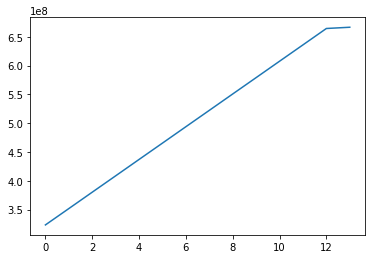

In [5]:
import matplotlib.pyplot as plt

plt.plot(memory)